# Optimizing the Initialization II

https://youtu.be/P6sfmUTpUmc?si=w0jn8hUg_DLZvr7Z&t=1676

## Utilities

In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Simple save and load functions
# save_model(parameters)
def save_model(parameters, filename="model.pt"):
    """Save model parameters"""
    torch.save(parameters, filename)
    print(f"Model saved to {filename}")

# To load later (after kernel restart):
# parameters = load_model()
def load_model(filename="model.pt"):
    """Load model parameters"""
    parameters = torch.load(filename)
    for p in parameters:
        p.requires_grad = True
    print(f"Model loaded from {filename}")
    return parameters

## Building Dataset

In [20]:
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print("Number of Words: ", len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Number of Words:  32033


In [21]:
# character list
chars = sorted(list(set(''.join(words))))
chars.insert(0, '.') # special starter/terminator character

# string to integer
stoi = {s: i for i, s in enumerate(chars)}

# integer to string
itos = {i: s for s, i in stoi.items()}

In [22]:
block_size = 3

def build_dataset(words):

    X, Y = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [23]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr    = build_dataset(words[:n1])         # Training Set: 80%
Xdev, Ydev  = build_dataset(words[n1:n2])       # Development Set: 10%
Xte, Yte    = build_dataset(words[n2:])         # Testing Set: 10%

## Building Model

In [24]:
# MLP Revisited
vocab_size = len(chars)
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                   generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g)
b1 = torch.randn((n_hidden),                            generator=g) * 0.2
W2 = torch.randn((n_hidden, vocab_size),                generator=g) * 0.01
b2 = torch.randn((vocab_size),                          generator=g) * 0

parameters = [C, W1, b1, W2, b2]

# set parameters for back propagation
for p in parameters:
    p.requires_grad = True

In [ ]:
# training the neural net
max_steps = 200000 # number training epochs
batch_size = 32 # number of samples processed per training epoch
lossi = []

n_total_samples = Xtr.shape[0]

for i in range(max_steps):

    # random sampling from dataset
    ix = torch.randint(0, n_total_samples, (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output later
    loss = F.cross_entropy(logits, Yb) # loss function

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if i % 10000 == 0: # print every 10000 steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item()) # Fixed indentation - now inside the loop

In [25]:
save_model(parameters='parameters_makemore_III.pt')

Model saved to model.pt


## Evaluating the Model

In [ ]:
load_model(filename='parameters_makemore_III.pt')

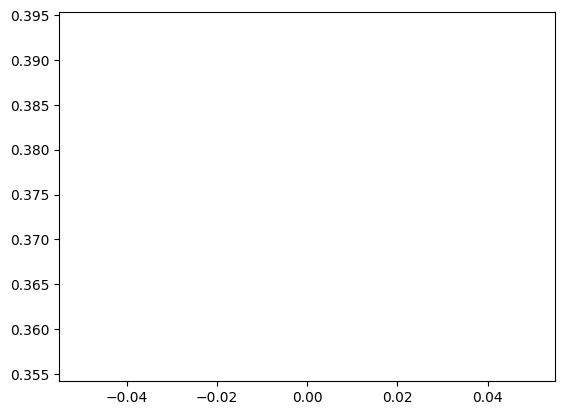

In [ ]:
plt.plot(lossi)

Train / Test Loss Comparison

In [ ]:
@torch.no_grad # disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1) # )(N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.131074905395508


## Sampling from the Model

In [ ]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size

    while True:
        # forward pass
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift context window
        context = context[1:] + [ix]
        out.append(ix)

        # if we get special . token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carman.
amille.
khyrmyn.
reet.
khalayane.
mahnen.
deliah.
jareei.
nellara.
chaiivon.
legen.
ham.
jorn.
quintin.
lilea.
jadiquinterri.
jarysia.
kael.
dustine.
deciia.


# Notes

tensor(-0.0054) tensor(1.0077)
tensor(0.0018) tensor(0.9836)


(array([2.39824823e-05, 0.00000000e+00, 2.39824823e-05, 2.39824823e-05,
        7.19474468e-05, 7.19474468e-05, 2.15842341e-04, 4.07702199e-04,
        4.79649646e-04, 6.95491986e-04, 2.13444092e-03, 2.87789787e-03,
        4.50870667e-03, 8.39386880e-03, 1.22550484e-02, 1.89941260e-02,
        3.00980153e-02, 4.20652739e-02, 6.15150670e-02, 8.87351844e-02,
        1.26387682e-01, 1.76559035e-01, 2.25075596e-01, 2.81266552e-01,
        3.38129018e-01, 3.86237877e-01, 4.26840220e-01, 4.36840915e-01,
        4.18854053e-01, 3.74030794e-01, 3.31102150e-01, 2.67644502e-01,
        2.07232629e-01, 1.55886135e-01, 1.18785235e-01, 8.13965449e-02,
        5.92127487e-02, 4.01946403e-02, 2.68843626e-02, 1.66678252e-02,
        1.03604323e-02, 6.90695490e-03, 3.86117965e-03, 2.90188036e-03,
        1.63080879e-03, 7.19474468e-04, 5.99562057e-04, 4.31684681e-04,
        2.15842341e-04, 4.79649646e-05]),
 array([-5.70546007, -5.49697456, -5.28848906, -5.08000355, -4.87151804,
        -4.66303253, 

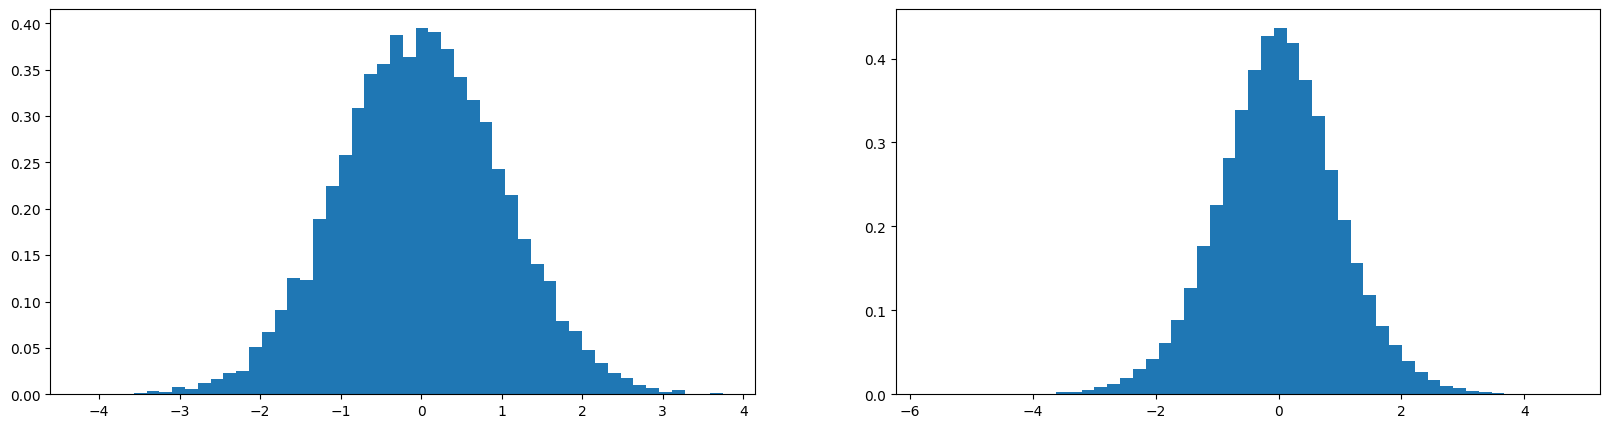

In [17]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5 # number of inputs squared
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)